In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_all = pd.read_csv('consensus.csv', parse_dates=True)

## Data wrangling

In [83]:
# Load stocks in the list
#stocks = ['AMZN', 'WMT', 'KO', 'XOM', 'CVX']
stocks = ['VLO', 'MRO', 'FANG', 'NKE', 'LULU', 'DIS', 'BKNG', 'BABA', 'SBUX', 'UAA', 'CMG', 'TSLA', 'NFLX', 'F',\
         'HD', 'MCD', 'TGT', 'KORS', 'GRPN', 'TRIP', 'JCP', 'WYNN', 'EXPE', \
         'IBM', 'PYPL', 'AMD', 'MSFT', 'V', 'TWTR', 'INTC', 'GOOGL', 'MA', 'EBAY', 'BIDU', 'FB', 'EA', 'FIT', 'GPRO',\
         'AAPL', 'QCOM', 'ATVI', 'YELP', 'CSCO', 'NVDA', 'CRM',\
         'COST', 'WMT', 'KO', 'PEP', 'CVS', 'PG', 'MNST',\
         'XOM', 'SLB', 'DVX', 'HAL', 'KMI', 'RIG', 'DVN', 'APC',\
         'JNJ', 'GILD', 'CELG', 'BHC', 'ISRG', 'AMGN', 'PFE', 'ILMN',\
         'ARNC', 'GE', 'BA', 'DAL', 'CAT', 'FDX', 'JBLU', 'LUV', 'DE',\
         'X', 'FCX', 'MON', 'ALB', 'FMC', 'OLN', 'CF', 'AKS',\
         'T', 'VZ', 'TMUS', 'S']

df = df_all[df_all['ticker'] == stocks[0]]

for i in stocks[1:]:
    temp = df_all[df_all['ticker'] == i]
    df = pd.concat([df, temp])    

In [84]:
len(stocks)

89

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377963 entries, 903486 to 2770756
Data columns (total 22 columns):
date                         377963 non-null object
ticker                       377963 non-null object
cusip                        377963 non-null object
fiscal_year                  377963 non-null int64
fiscal_quarter               377963 non-null int64
reports_at                   377963 non-null object
estimize.eps.weighted        376145 non-null float64
estimize.eps.mean            375225 non-null float64
estimize.eps.high            375225 non-null float64
estimize.eps.low             375225 non-null float64
estimize.eps.sd              375225 non-null float64
estimize.eps.count           375225 non-null float64
estimize.revenue.weighted    354019 non-null float64
estimize.revenue.mean        354160 non-null float64
estimize.revenue.high        354160 non-null float64
estimize.revenue.low         354160 non-null float64
estimize.revenue.sd          354160 non-nul

In [86]:
#Since we will need columns such as 'estimize.eps.sd' to calculate the Delta, drop all rows with NaN values:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281569 entries, 903486 to 2770395
Data columns (total 22 columns):
date                         281569 non-null object
ticker                       281569 non-null object
cusip                        281569 non-null object
fiscal_year                  281569 non-null int64
fiscal_quarter               281569 non-null int64
reports_at                   281569 non-null object
estimize.eps.weighted        281569 non-null float64
estimize.eps.mean            281569 non-null float64
estimize.eps.high            281569 non-null float64
estimize.eps.low             281569 non-null float64
estimize.eps.sd              281569 non-null float64
estimize.eps.count           281569 non-null float64
estimize.revenue.weighted    281569 non-null float64
estimize.revenue.mean        281569 non-null float64
estimize.revenue.high        281569 non-null float64
estimize.revenue.low         281569 non-null float64
estimize.revenue.sd          281569 non-nul

In [87]:
#To see if there are multiple entries for the 'date' column:
df.groupby('date').size().sort_values(ascending=False).head(2)

date
2017-01-24    346
2017-01-17    345
dtype: int64

In [88]:
# For each stock, drop duplicated rows for the same 'reports_at' dates
df1 = pd.DataFrame()
for i in stocks: 
    temp = df[df['ticker'] == i]
    temp.drop_duplicates(subset='reports_at', keep='last', inplace=True)
    df1 = pd.concat([df1, temp]) 

In [98]:
# Drop the stocks that do not have long history, i.e., drop those with earliest date > 2012-05-01
df2 = pd.DataFrame()
for i in stocks: 
    temp = df1[df1['ticker'] == i]
    
    # Reset index because original dataframe has other assigned indices not starting from 0:
    temp2 = temp.reset_index()
    
    # Convert the 'date' column into datetime objects:
    temp2['datetime'] = pd.to_datetime(temp2['date'])
    
    if temp2['datetime'].min() < datetime.strptime('2012-05-01', '%Y-%m-%d'):
        df2 = pd.concat([df2, temp2])          

Extract the date and time components of the "reports_at" column respectively, to be uploaded to Quantopian, to retain the correct date info. 

In [103]:
# Extract the date and time components of the "reports_at" column respectively:
DT = []
TM = []
for row in df2['reports_at']:
    temp = str(row)
    # date
    DT.append(temp[0:10]) 
    #time
    TM.append(temp[11:]) 

df2['DT'] = DT
df2['TM'] = TM

In [104]:
df2

,index,date,ticker,cusip,fiscal_year,fiscal_quarter,reports_at,estimize.eps.weighted,estimize.eps.mean,estimize.eps.high,...,estimize.revenue.low,estimize.revenue.sd,estimize.revenue.count,wallstreet.eps,wallstreet.revenue,actual.eps,actual.revenue,datetime,DT,TM
0,207359,2011-12-20,NKE,654106103,2012,2,2011-12-20T16:00:00-05:00,0.249322,0.248333,0.27,...,5360.00,139.811381,6.0,0.250,5630.410,0.25,5731.00,2011-12-20,2011-12-20,16:00:00-05:00
1,207363,2012-03-22,NKE,654106103,2012,3,2012-03-22T16:00:00-04:00,0.308655,0.311000,0.33,...,5800.00,83.570330,10.0,0.290,5820.000,0.30,5846.00,2012-03-22,2012-03-22,16:00:00-04:00
2,207380,2012-06-28,NKE,654106103,2012,4,2012-06-28T16:00:00-04:00,0.342563,0.342667,0.37,...,6452.00,45.454446,15.0,0.340,6490.030,0.30,6470.00,2012-06-28,2012-06-28,16:00:00-04:00
3,207403,2012-09-27,NKE,654106103,2013,1,2012-09-27T16:00:00-04:00,0.283938,0.285789,0.33,...,6139.00,95.535000,57.0,0.280,6437.551,0.32,6474.00,2012-09-27,2012-09-27,16:00:00-04:00
4,207421,2012-12-20,NKE,654106103,2013,2,2012-12-20T16:00:00-05:00,0.265057,0.263611,0.31,...,5890.00,95.311231,36.0,0.250,5990.000,0.28,5955.00,2012-12-20,2012-12-20,16:00:00-05:00
5,207493,2013-06-27,NKE,654106103,2013,4,2013-06-27T16:00:00-04:00,0.385781,0.384583,0.40,...,6486.00,53.894943,24.0,0.370,6658.603,0.38,6700.00,2013-06-27,2013-06-27,16:00:00-04:00
6,207544,2013-09-26,NKE,654106103,2014,1,2013-09-26T16:00:00-04:00,0.405873,0.404118,0.42,...,6919.00,24.518759,17.0,0.390,6972.532,0.43,6970.00,2013-09-26,2013-09-26,16:00:00-04:00
7,207581,2013-12-19,NKE,654106103,2014,2,2013-12-19T16:00:00-05:00,0.313021,0.312727,0.34,...,6445.00,45.450788,33.0,0.290,6455.568,0.30,6431.00,2013-12-19,2013-12-19,16:00:00-05:00
8,207673,2014-03-20,NKE,654106103,2014,3,2014-03-20T16:00:00-04:00,0.374970,0.378723,0.43,...,6704.00,47.035975,47.0,0.360,6818.076,0.38,6972.00,2014-03-20,2014-03-20,16:00:00-04:00
9,207820,2014-06-26,NKE,654106103,2014,4,2014-06-26T16:00:00-04:00,0.393636,0.394792,0.43,...,7266.00,75.098442,48.0,0.380,7346.450,0.39,7425.00,2014-06-26,2014-06-26,16:00:00-04:00


### Calculate the deltas for eps and revenues:

In [105]:
# eps delta between actual eps and Estimize eps:
df2['eps_del_actual'] = (df2['actual.eps'] - df2['estimize.eps.weighted']) / (df2['estimize.eps.sd'] + 0.01)

# eps delta between Wall Street eps and Estimize eps:
df2['eps_del_Wall'] = (df2['wallstreet.eps'] - df2['estimize.eps.weighted']) / (df2['estimize.eps.sd'] + 0.01)

# revenue delta between actual revenue and Estimize revenue:
df2['rev_del_actual'] = (df2['actual.revenue'] - df2['estimize.revenue.weighted']) / (df2['estimize.revenue.sd'] + 0.01)

# revenue delta between Wall Street revenue and Estimize revenue:
df2['rev_del_Wall'] = (df2['wallstreet.revenue'] - df2['estimize.revenue.weighted']) / (df2['estimize.revenue.sd'] + 0.01)

## Exploratory Data Visualisation

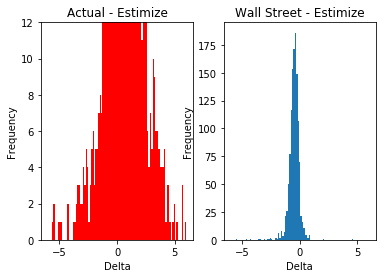

In [106]:
plt.subplot(121)
bins = np.linspace(-6, 6, 100)
plt.hist(df2['eps_del_actual'], bins, color='red')
plt.title("Actual - Estimize")
plt.xlabel("Delta")
plt.ylabel("Frequency")
plt.ylim([0,12])

plt.subplot(122)
plt.hist(df2['eps_del_Wall'], bins)
plt.title("Wall Street - Estimize")
plt.xlabel("Delta")
plt.ylabel("Frequency")
plt.show()

Looks like the eps delta between Wall Street and Estimize predictions is more consistent than the delta between Actual predictions and Estimize predictions. 

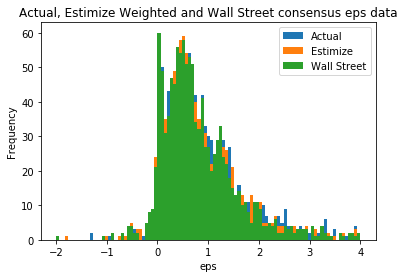

In [107]:
bins = np.linspace(-2, 4, 100)
plt.hist(df2['actual.eps'], bins)
plt.hist(df2['estimize.eps.weighted'], bins)
plt.hist(df2['wallstreet.eps'], bins)
plt.title("Actual, Estimize Weighted and Wall Street consensus eps data")
plt.legend(["Actual", "Estimize", "Wall Street"]) 
plt.xlabel("eps")
plt.ylabel("Frequency")
plt.show()

# TO ADD SUBPLOT FOR REVENUE DATA!!!

#### Box plot

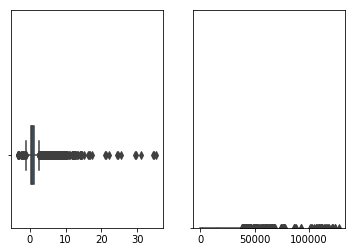

In [109]:
plt.subplot(121)
df_plot_eps = pd.concat([df2['actual.eps'], df2['estimize.eps.weighted'], df2['wallstreet.eps']], axis=1)
sns.boxplot(df_plot_eps)
plt.ylim([-1,2])

plt.subplot(122)
df_plot_rev = pd.concat([df2['actual.revenue'], df2['estimize.revenue.weighted'], df2['wallstreet.revenue']], axis=1)
sns.boxplot(df_plot_rev)
plt.ylim([0,50000])
plt.show()

### Beeswarm plots

KeyboardInterrupt: 

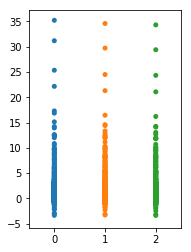

In [110]:
plt.subplot(121)
sns.swarmplot(data=df_plot_eps)
plt.ylim([-1.5,4])

plt.subplot(122)
sns.swarmplot(data=df_plot_rev)
#plt.ylim([0,3000])
plt.show()

It seems that the actual eps has greater range than the Wall Street and Estimize preditions, whereas for the revenues, it is hard to tell. 

## Preparing data for Quantopian upload
#### From Quantopian website: 
"During the historical upload, Quantopian will translate the primary date column values into a historical timestamp by adding a historical lag (default: one day).

Trade Date Signals: If your date field represents the day you expect an algorithm to act on the signal, you should create a trade_date_minus_one column that can be used as the primary date column."

In [111]:
df_quanto = df2[['date', 'ticker', 'DT', 'TM', 'eps_del_actual', 'eps_del_Wall', 'rev_del_actual', 'rev_del_Wall']]

In [112]:
df_quanto

,date,ticker,DT,TM,eps_del_actual,eps_del_Wall,rev_del_actual,rev_del_Wall
0,2011-12-20,NKE,2011-12-20,16:00:00-05:00,0.025349,0.025349,0.610956,-0.108461
1,2012-03-22,NKE,2012-03-22,16:00:00-04:00,-0.423408,-0.912638,-0.588639,-0.899717
2,2012-06-28,NKE,2012-06-28,16:00:00-04:00,-1.818936,-0.109522,-0.997588,-0.557024
3,2012-09-27,NKE,2012-09-27,16:00:00-04:00,1.494150,-0.163153,0.393817,0.012332
4,2012-12-20,NKE,2012-12-20,16:00:00-05:00,0.657528,-0.662525,-1.373735,-1.006556
5,2013-06-27,NKE,2013-06-27,16:00:00-04:00,-0.309949,-0.846135,0.843783,0.075820
6,2013-09-26,NKE,2013-09-26,16:00:00-04:00,1.361975,-0.896045,-0.543990,-0.440764
7,2013-12-19,NKE,2013-12-19,16:00:00-05:00,-0.634423,-1.121669,-1.198890,-0.658468
8,2014-03-20,NKE,2014-03-20,16:00:00-04:00,0.190139,-0.565910,2.824979,-0.446799
9,2014-06-26,NKE,2014-06-26,16:00:00-04:00,-0.166017,-0.622626,0.024185,-1.021636


In [113]:
# rename columns so that Quantopian can understand:
df_quanto.columns = ['asof_date', 'symbol', 'DT', 'TM', 'actual_del_eps', 'wal_del_eps', 'rev_del_actual', 'wal_del_rev']
df_quanto.reset_index()

,index,asof_date,symbol,DT,TM,actual_del_eps,wal_del_eps,rev_del_actual,wal_del_rev
0,0,2011-12-20,NKE,2011-12-20,16:00:00-05:00,0.025349,0.025349,0.610956,-0.108461
1,1,2012-03-22,NKE,2012-03-22,16:00:00-04:00,-0.423408,-0.912638,-0.588639,-0.899717
2,2,2012-06-28,NKE,2012-06-28,16:00:00-04:00,-1.818936,-0.109522,-0.997588,-0.557024
3,3,2012-09-27,NKE,2012-09-27,16:00:00-04:00,1.494150,-0.163153,0.393817,0.012332
4,4,2012-12-20,NKE,2012-12-20,16:00:00-05:00,0.657528,-0.662525,-1.373735,-1.006556
5,5,2013-06-27,NKE,2013-06-27,16:00:00-04:00,-0.309949,-0.846135,0.843783,0.075820
6,6,2013-09-26,NKE,2013-09-26,16:00:00-04:00,1.361975,-0.896045,-0.543990,-0.440764
7,7,2013-12-19,NKE,2013-12-19,16:00:00-05:00,-0.634423,-1.121669,-1.198890,-0.658468
8,8,2014-03-20,NKE,2014-03-20,16:00:00-04:00,0.190139,-0.565910,2.824979,-0.446799
9,9,2014-06-26,NKE,2014-06-26,16:00:00-04:00,-0.166017,-0.622626,0.024185,-1.021636


In [114]:
# write out the dataframe as .csv file:
df_quanto.to_csv('89_stocks.csv', index = False)

In [4]:
check = pd.read_csv('89_stocks.csv')

In [5]:
check.head()

,asof_date,symbol,DT,TM,actual_del_eps,wal_del_eps,rev_del_actual,wal_del_rev
0,2011-12-20,NKE,2011-12-20,16:00:00-05:00,0.025349,0.025349,0.610956,-0.108461
1,2012-03-22,NKE,2012-03-22,16:00:00-04:00,-0.423408,-0.912638,-0.588639,-0.899717
2,2012-06-28,NKE,2012-06-28,16:00:00-04:00,-1.818936,-0.109522,-0.997588,-0.557024
3,2012-09-27,NKE,2012-09-27,16:00:00-04:00,1.494150,-0.163153,0.393817,0.012332
4,2012-12-20,NKE,2012-12-20,16:00:00-05:00,0.657528,-0.662525,-1.373735,-1.006556


In [8]:
# Drop stock 'GOOGL', as it has inconsistent ticker in other systems:
check = check[check.symbol != 'GOOGL']

In [9]:
# Get stocks in the 'symbol' column:
stocks_condensed = check.symbol.unique()
stocks_condensed

array(['NKE', 'LULU', 'DIS', 'BKNG', 'SBUX', 'UAA', 'CMG', 'TSLA', 'NFLX',
       'F', 'MCD', 'TGT', 'GRPN', 'EXPE', 'IBM', 'AMD', 'MSFT', 'V',
       'INTC', 'MA', 'EBAY', 'BIDU', 'FB', 'EA', 'AAPL', 'QCOM', 'ATVI',
       'CSCO', 'NVDA', 'CRM', 'COST', 'KO', 'PEP', 'XOM', 'SLB', 'HAL',
       'CELG', 'ISRG', 'ARNC', 'GE', 'BA', 'CAT', 'FDX', 'FCX', 'MON',
       'T', 'VZ'], dtype=object)

In [10]:
len(stocks_condensed)

47

In [117]:
d = check.sort_values(by='DT')
d.iloc[0, :].DT # First date of data

'2010-10-18'

In [118]:
d.iloc[-1, :].DT # Last date of data

'2018-07-16'